In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Name

In [3]:
import string
def get_title(x):
    name_parts = x.split(',')
    title = name_parts[1].split('.')[0].strip()
    return title

In [4]:
train['Title'] = train['Name'].map(lambda x: get_title(x))

train.loc[train['Title'] == 'Don', 'Title'] = 'Mr'
train.loc[train['Title'] == 'Major', 'Title'] = 'Mr'
train.loc[train['Title'] == 'Capt', 'Title'] = 'Mr'
train.loc[train['Title'] == 'Jonkheer', 'Title'] = 'Mr'
train.loc[train['Title'] == 'Rev', 'Title'] = 'Mr'
train.loc[train['Title'] == 'Col', 'Title'] = 'Mr'
train.loc[train['Title'] == 'Countess', 'Title'] = 'Mrs'
train.loc[train['Title'] == 'Mme', 'Title'] = 'Mrs'
train.loc[train['Title'] == 'Mlle', 'Title'] = 'Miss'
train.loc[train['Title'] == 'Ms', 'Title'] = 'Miss'
train.loc[(train['Title'] == 'Dr') & (train['Sex'] == 'male'), 'Title'] = 'Mr'
train.loc[(train['Title'] == 'Dr') & (train['Sex'] == 'female'), 'Title'] = 'Mrs'
train.loc[train['Title'] == 'the Countess', 'Title'] = 'Mrs'
train.loc[train['Title'] == 'Lady', 'Title'] = 'Miss'
train.loc[train['Title'] == 'Sir', 'Title'] = 'Mr'

# Age

In [5]:
train['Age'] = train['Age'].fillna(train['Age'].median())

train.loc[train.Age <= 1.0, 'age_bins'] = '1s'
train.loc[(train['Age'] > 1.0) & (train['Age'] <= 5.0), 'age_bins'] = '5s'
train.loc[(train['Age'] > 5.0) & (train['Age'] <= 10.0), 'age_bins'] = '10s'
train.loc[(train['Age'] > 10.0) & (train['Age'] <= 15.0), 'age_bins'] = '15s'
train.loc[(train['Age'] > 15.0) & (train['Age'] <= 20.0), 'age_bins'] = '20s'
train.loc[(train['Age'] > 20.0) & (train['Age'] <= 25.0), 'age_bins'] = '25s'
train.loc[(train['Age'] > 25.0) & (train['Age'] <= 30.0), 'age_bins'] = '30s'
train.loc[(train['Age'] > 30.0) & (train['Age'] <= 35.0), 'age_bins'] = '35s'
train.loc[(train['Age'] > 35.0) & (train['Age'] <= 40.0), 'age_bins'] = '40s'
train.loc[(train['Age'] > 40.0) & (train['Age'] <= 45.0), 'age_bins'] = '45s'
train.loc[(train['Age'] > 45.0) & (train['Age'] <= 50.0), 'age_bins'] = '50s'
train.loc[(train['Age'] > 50.0) & (train['Age'] <= 55.0), 'age_bins'] = '55s'
train.loc[(train['Age'] > 55.0), 'age_bins'] = '60s'

# SibSp & Parch  

In [6]:
train['relative_size'] = train['SibSp'] + train['Parch']
train.loc[train['relative_size'] > 0, 'travelled_alone'] = 0 #No
train.loc[train['relative_size'] == 0, 'travelled_alone'] = 1 #Yes

# Cabin

In [7]:
train['Cabin'].loc[~train['Cabin'].isnull()] = 1  
train['Cabin'].loc[train['Cabin'].isnull()] = 0 

B:\Anaconda\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# Embarked

In [8]:
train['Embarked'] = train['Embarked'].fillna('S')

# Fare

In [9]:
Q1 = train['Fare'].quantile(0.25)
Q3 = train['Fare'].quantile(0.75)
IQR = Q3 - Q1

lower_lim = Q1 - 1.5 * IQR
upper_lim = Q3 + 1.5 * IQR

train = train.drop(train[(train['Fare'] > upper_lim)].index)

# Drop Columns

In [10]:
train = train.drop(['PassengerId', 'Ticket', 'Name', 'Age'], axis=1)

train['travelled_alone'] = train['travelled_alone'].astype(int)

train.reset_index(drop=True, inplace=True)

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False, drop='first')
data_obj = ohe.fit_transform(train[train.columns[train.dtypes=='object']])

obj_df = pd.DataFrame(data_obj,columns=ohe.get_feature_names(train.columns[train.dtypes=='object']))
cat_columns = obj_df.columns

train = pd.concat([train[train.columns[train.dtypes!='object']], obj_df], axis=1)

train = (train-train.min())/(train.max()-train.min())

# Feature Importances

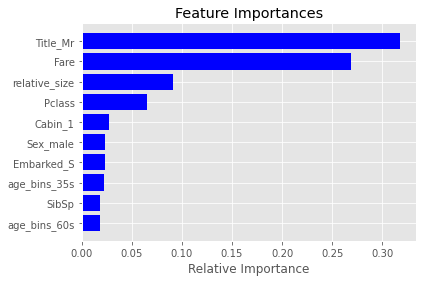

In [11]:
from sklearn.ensemble import RandomForestRegressor

X = train.drop('Survived', axis=1)
y = train['Survived']

model = RandomForestRegressor(random_state=1, max_depth=10)
model.fit(X,y)

features = X.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [12]:
sex = [col for col in train.columns if 'Sex' in col]
cabin = [col for col in train.columns if 'Cabin' in col]
age_bins = [col for col in train.columns if 'age_bins' in col]
title = [col for col in train.columns if 'Title' in col]

features = ['Pclass', 'Fare', 'relative_size'] + sex + cabin + age_bins + title
train[features]

,Pclass,Fare,relative_size,Sex_male,Cabin_1,age_bins_15s,age_bins_1s,age_bins_20s,age_bins_25s,age_bins_30s,age_bins_35s,age_bins_40s,age_bins_45s,age_bins_50s,age_bins_55s,age_bins_5s,age_bins_60s,Title_Miss,Title_Mr,Title_Mrs
0,1.0,0.111538,0.142857,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.121923,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.816923,0.142857,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.123846,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.130128,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,0.5,0.200000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
771,0.0,0.461538,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
772,1.0,0.360769,0.428571,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
773,0.0,0.461538,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Models

In [13]:
from sklearn.model_selection import train_test_split

X = train[features]
y = train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

## Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

LogisticRegression()

In [15]:
from sklearn import metrics

log_pred = logmodel.predict(X_test)
log_acc = metrics.r2_score(y_test, log_pred)
print('Accuracy:', str(format(log_acc*100, '.3f')) + '%')

Accuracy: 39.789%


## KNN

In [16]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = neighbors.KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

knn_acc = knn.score(X_test, y_test)
print('Accuracy:', str(format(knn_acc*100, '.3f')) + '%')

Accuracy: 78.065%


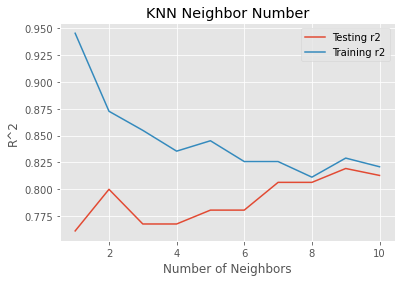

In [17]:
neighbors = np.arange(1,11)
train_r2 = np.empty(len(neighbors))
test_r2 = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    train_r2[i] = knn.score(X_train, y_train)
    test_r2[i] = knn.score(X_test, y_test)

plt.title('KNN Neighbor Number')
plt.plot(neighbors, test_r2, label = 'Testing r2')
plt.plot(neighbors, train_r2, label = 'Training r2')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('R^2')
plt.show()

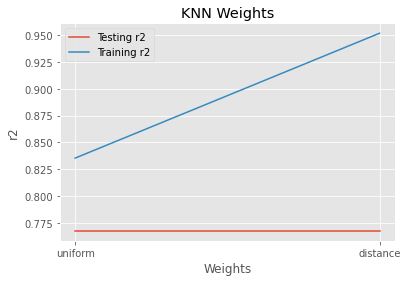

In [18]:
weights_opt = ['uniform', 'distance']
train_r2 = np.empty(len(weights_opt))
test_r2 = np.empty(len(weights_opt))

for i in range(len(weights_opt)):
    knn = KNeighborsClassifier(n_neighbors = 4, weights = weights_opt[i])
    knn.fit(X_train, y_train)
    train_r2[i] = knn.score(X_train, y_train)
    test_r2[i] = knn.score(X_test, y_test)

plt.title('KNN Weights')
plt.plot(weights_opt, test_r2, label = 'Testing r2')
plt.plot(weights_opt, train_r2, label = 'Training r2')
plt.legend()
plt.xlabel('Weights')
plt.ylabel('r2')
plt.show()

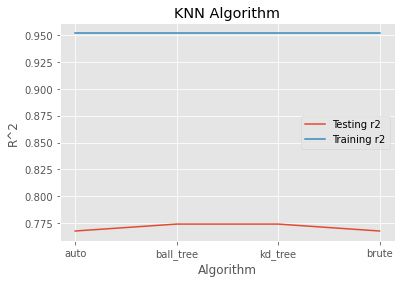

In [19]:
alg = ['auto', 'ball_tree', 'kd_tree', 'brute']
train_r2 = np.empty(len(alg))
test_r2 = np.empty(len(alg))

for i in range(len(alg)):
    knn = KNeighborsClassifier(n_neighbors = 4, weights = 'distance', algorithm = alg[i])
    knn.fit(X_train, y_train)
    train_r2[i] = knn.score(X_train, y_train)
    test_r2[i] = knn.score(X_test, y_test)

plt.title('KNN Algorithm')
plt.plot(alg, test_r2, label = 'Testing r2')
plt.plot(alg, train_r2, label = 'Training r2')
plt.legend()
plt.xlabel('Algorithm')
plt.ylabel('R^2')
plt.show()

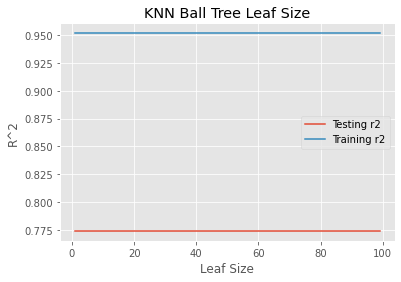

In [20]:
leaf = np.arange(1,100)
train_r2 = np.empty(len(leaf))
test_r2 = np.empty(len(leaf))

for i,k in enumerate(leaf):
    knn = KNeighborsClassifier(n_neighbors = 4, weights = 'distance', algorithm = 'ball_tree', leaf_size = k)
    knn.fit(X_train, y_train)
    train_r2[i] = knn.score(X_train, y_train)
    test_r2[i] = knn.score(X_test, y_test)

plt.title('KNN Ball Tree Leaf Size')
plt.plot(leaf, test_r2, label = 'Testing r2')
plt.plot(leaf, train_r2, label = 'Training r2')
plt.legend()
plt.xlabel('Leaf Size')
plt.ylabel('R^2')
plt.show()

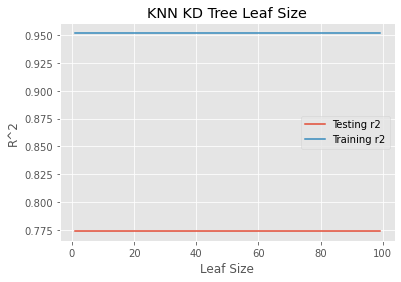

In [21]:
leaf = np.arange(1,100)
train_r2 = np.empty(len(leaf))
test_r2 = np.empty(len(leaf))

for i,k in enumerate(leaf):
    knn = KNeighborsClassifier(n_neighbors = 4, weights = 'distance', algorithm = 'kd_tree', leaf_size = k)
    knn.fit(X_train, y_train)
    train_r2[i] = knn.score(X_train, y_train)
    test_r2[i] = knn.score(X_test, y_test)

plt.title('KNN KD Tree Leaf Size')
plt.plot(leaf, test_r2, label = 'Testing r2')
plt.plot(leaf, train_r2, label = 'Training r2')
plt.legend()
plt.xlabel('Leaf Size')
plt.ylabel('R^2')
plt.show()

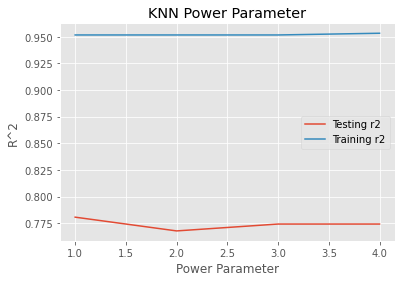

In [22]:
p = np.arange(1,5)
train_r2 = np.empty(len(p))
test_r2 = np.empty(len(p))

for i,k in enumerate(p):
    knn = KNeighborsClassifier(n_neighbors = 4, weights = 'distance', algorithm = 'auto', p = k)
    knn.fit(X_train, y_train)
    train_r2[i] = knn.score(X_train, y_train)
    test_r2[i] = knn.score(X_test, y_test)

plt.title('KNN Power Parameter')
plt.plot(p, test_r2, label = 'Testing r2')
plt.plot(p, train_r2, label = 'Training r2')
plt.legend()
plt.xlabel('Power Parameter')
plt.ylabel('R^2')
plt.show()

In [23]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = neighbors.KNeighborsClassifier(n_neighbors = 9, weights = 'distance', algorithm = 'kd_tree', p = 1)
knn.fit(X_train, y_train)

knn_acc = knn.score(X_test, y_test)
print('Accuracy:', str(format(knn_acc*100, '.3f')) + '%')

Accuracy: 80.000%


## Naive Bayes

In [24]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

nb = GaussianNB()
nb.fit(X_train, y_train)

nb_pred = nb.predict(X_test)

nb_acc = accuracy_score(y_test, nb_pred)
print('Accuracy:', str(format(nb_acc*100, '.3f')) + '%')

Accuracy: 76.129%


## SVM

In [25]:
from sklearn.svm import SVR

svr = SVR(kernel = 'linear', C = 0.1, gamma = 1)
svr.fit(X_train, y_train)

svr_pred = svr.predict(X_test)

svr_acc = metrics.r2_score(y_test, svr_pred)
print('Accuracy:', str(format(svr_acc*100, '.3f')) + '%')

Accuracy: 24.593%


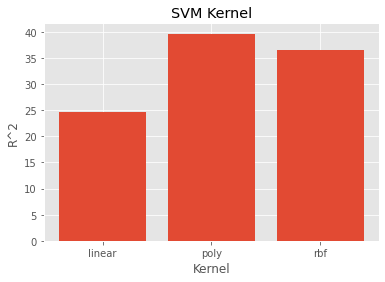

In [26]:
kernel = ['linear', 'poly', 'rbf']
svm_r2 = []
for i in range(3):
    svr = SVR(kernel = kernel[i], C = 0.1, gamma = 1)
    svr.fit(X_train, y_train)
    svr_pred = svr.predict(X_test)
    svm_r2.append(100*metrics.r2_score(y_test, svr_pred))

plt.bar(kernel,svm_r2)
plt.title('SVM Kernel')
plt.xlabel('Kernel')
plt.ylabel('R^2')
plt.show()

In [27]:
svr = SVR(kernel = 'poly', C = 0.1, gamma = 1)
svr.fit(X_train, y_train)

svr_pred = svr.predict(X_test)

svr_acc = metrics.r2_score(y_test, svr_pred)
print('Accuracy:', str(format(svr_acc*100, '.3f')) + '%')

Accuracy: 39.654%


In [28]:
svr = SVR(kernel = 'poly', C = 100, gamma = 1)
svr.fit(X_train, y_train)

svr_pred = svr.predict(X_test)

svr_acc = metrics.r2_score(y_test, svr_pred)
print('Accuracy:', str(format(svr_acc*100, '.3f')) + '%')

Accuracy: -78.412%


# Model Selection

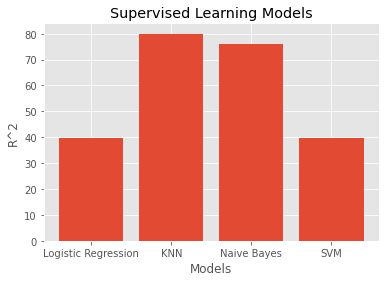

In [29]:
model = ['Logistic Regression', 'KNN', 'Naive Bayes', 'SVM']
acc = [39.79, 80.0, 76.13, 39.654]

plt.bar(model, acc)
plt.title('Supervised Learning Models')
plt.xlabel('Models')
plt.ylabel('R^2')
plt.show()

## KNN and Naive Bayes had the highest R^2 values